# XCALE Master thesis : DBN Building v2

In this notebook, we build the dbn dataset

<style>.table {margin-left:0px}</style>

## Import

In [1]:
# data handling
import numpy as np
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10

In [20]:
# Database
#!sudo apt-get install python3-dev default-libmysqlclient-dev
!pip install mysql-connector-python
from mysql.connector import connect
# error
import traceback
from collections import defaultdict
from datetime import time, timedelta, datetime
# utilitaries
import functools
import tqdm

import matplotlib.pyplot as plt
import scipy.stats as stats

## Database

In [3]:
# Log
_db_config = {
    'user': 'cajuge',
    'password': 'Kz1773qMWIVhRZUZ',
    'host': 'franceioi.cinniket56wn.eu-central-1.rds.amazonaws.com',
    'database': 'srl',
    'port':'3306'
}

In [4]:
_tables = ["clavier", "modification",
          "navigation", "pas_a_pas","srl_final_prompt",
          "srl_initial_prompt","srl_prompt","validation", "connexion"]

In [5]:
def get_connection(config):
    return connect(**config)
def close_connection(connection):
    connection.close()

In [6]:
def getTablesFromDB(min_id_connection, _tables):
    dataframe_tables = {}
    mysql_connection = get_connection(_db_config)
    for table in _tables:
        with mysql_connection.cursor() as cursor:
            try:
                # ----------- Get every connection / participant ---------- #
                if table == "connexion":
                    query_select = "SELECT c.id, c.timestamp FROM connexion c INNER JOIN participer p ON p.id = c.id_participation WHERE c.id >= %s AND p.id_activite=11 ORDER BY c.id, c.timestamp"
                    cursor.execute(query_select, (min_id_connection,))
                elif table == "validation":
                    query_select = "SELECT t.experimentation, t.score, t.id_connexion, t.timestamp FROM {} t INNER JOIN connexion c ON c.id = t.id_connexion INNER JOIN participer p ON p.id = c.id_participation WHERE c.id >= %s AND p.id_activite=11 ORDER BY c.id, c.timestamp".format(table)
                    cursor.execute(query_select, (min_id_connection,))
                else:
                    query_select = "SELECT t.id_connexion, t.timestamp FROM {} t INNER JOIN connexion c ON c.id = t.id_connexion INNER JOIN participer p ON p.id = c.id_participation WHERE c.id >= %s AND p.id_activite=11 ORDER BY c.id, c.timestamp".format(table)
                    cursor.execute(query_select, (min_id_connection,))
                
                result = cursor.fetchall()
                columns_name = np.array(
                    [cursor.description[i][0] for i in range(len(cursor.description)) if cursor.description[i][0]])
                data = []
                for row in result:
                    data.append(np.array([row[i] for i in range(len(row))]))
                dataframe_tables[table] = pd.DataFrame(data, columns=columns_name)
            except Exception:
                traceback.print_exc()
    
    
    return dataframe_tables

def getTablesFromDB_ids(ids, _tables):
    dataframe_tables = {}
    mysql_connection = get_connection(_db_config)
    for table in _tables:
        with mysql_connection.cursor() as cursor:
            try:
                # ----------- Get every connection / participant ---------- #
                format_strings = ','.join(['%s'] * len(ids))
                if table == "connexion":
                    query_select = "SELECT * FROM connexion WHERE id IN ({}) ORDER BY id, timestamp".format(format_strings)
                else:
                    query_select = "SELECT * FROM {} WHERE id_connexion IN ({}) ORDER BY id_connexion, timestamp".format(table, format_strings)
                
                cursor.execute(query_select, tuple(ids))
                result = cursor.fetchall()
                columns_name = np.array(
                    [cursor.description[i][0] for i in range(len(cursor.description)) if cursor.description[i][0]])
                data = []
                for row in result:
                    data.append(np.array([row[i] for i in range(len(row))]))
                dataframe_tables[table] = pd.DataFrame(data, columns=columns_name)
            except Exception:
                traceback.print_exc()
    
    
    return dataframe_tables

In [7]:
dataframe_tables = getTablesFromDB(191, _tables)

In [8]:
table = "connexion"
sujet_range = [19,20,21,22,23,24,25,26,27,28]
connections = dataframe_tables[table]
nb_connection_1h = []
for j, id_connexion in enumerate(connections.id):
    last_timestamp_table = []
    for table in [i for i in _tables if i != "connexion"]:
        sequence = dataframe_tables[table][dataframe_tables[table].id_connexion == id_connexion].timestamp
        if len(sequence) != 0:
            last_timestamp_table.append(max(sequence))
    if len(last_timestamp_table) != 0:
        if max(last_timestamp_table) - connections.timestamp[j] >= timedelta(hours=1):
            if dataframe_tables["validation"].query("id_connexion == {} and experimentation == 0 and score > 0".format(id_connexion)).shape[0] != 0:
                nb_connection_1h.append(id_connexion)
print("{} registered connections which last at least 1 hour".format(len(nb_connection_1h)))

93 registered connections which last at least 1 hour


In [9]:
dataframe_tables = getTablesFromDB_ids(nb_connection_1h, _tables)

## Building V.2

<img src='https://drive.google.com/uc?id=19I5DHRi0Z1gI4wwqRsFSIkEz1rh9w8x3' />


In [10]:
data = [[] for _ in nb_connection_1h]
columns = []

In [11]:
df = dataframe_tables.copy()

## Data Indicators

### Timestamps

In [12]:
def get_important_timestamps(ids_connexion, df_prompt_middle, df_prompt_final, df_connexion):
    timestamps_middle = []
    timestamps_final = []
    for id_connexion in ids_connexion:
        temp_df = df_prompt_middle.query('id_connexion == {}'.format(id_connexion))
        if temp_df.shape[0] == 0:
            # the user doesn't not provide us prompts
            timestamp = list(df_connexion.query('id == {}'.format(id_connexion)).timestamp)[0]
            timestamps_middle.append(timestamp + timedelta(minutes=30))
            timestamps_final.append(timestamp + timedelta(hours=1))
        else:
            timestamp = list(temp_df.timestamp)[0]
            timestamps_middle.append(timestamp)
            #final
            temp_df = df_prompt_final.query('id_connexion == {}'.format(id_connexion))
            if temp_df.shape[0] == 0:
                # the user doesn't not provide us prompts
                timestamps_final.append(timestamp + timedelta(minutes=30))
            else:
                timestamps_final(list(temp_df.timestamp)[0])
    return [i.to_pydatetime() for i in timestamps_middle], [i.to_pydatetime() for i in timestamps_final]

In [13]:
def get_index_timestamp(df, timestamp1, timestamp2):
    column = list(df.columns).index("timestamp")
    return [row for row in range(df.shape[0]) if df.iloc[row, column] > timestamp1 and df.iloc[row, column] <= timestamp2]

In [14]:
def draw(data, columns, nb_connection_1h):
    return pd.DataFrame(data[:5], columns=columns, index=nb_connection_1h[:5])

In [15]:
def eliminate_same_subject_version_score(df):
    indexes = []
    uniques = list(df[["id_sujet", "version"]].value_counts().index)
    for i in range(len(uniques)):
        df_multiple = df.query("id_sujet == {} and version == {}".format(uniques[i][0], uniques[i][1]))
        indexes.append(list(df_multiple.index)[-1])
    return indexes

In [16]:
def eliminate_same_subject_version_following(df, col1, col2):
    indexes = []
    memory = None
    for i in range(df.shape[0]):
        if memory == None:
            memory = (df.iloc[i,col1], df.iloc[i,col2])
            indexes.append(i)
        else:
            if df.iloc[i,col1] != memory[0] or df.iloc[i,col2] != memory[1]:
                memory = (df.iloc[i,col1], df.iloc[i,col2])
                indexes.append(i)
    return indexes

def eliminate_same_subject_version_other_following(df, col1, col2, col3):
    indexes = []
    memory = None
    for i in range(df.shape[0]):
        if memory == None:
            memory = (df.iloc[i,col1], df.iloc[i,col2], df.iloc[i,col3])
            indexes.append(i)
        else:
            if df.iloc[i,col1] != memory[0] or df.iloc[i,col2] != memory[1] or df.iloc[i,col3] != memory[2]:
                memory = (df.iloc[i,col1], df.iloc[i,col2], df.iloc[i,col3])
                indexes.append(i)
    return indexes

In [17]:
beginning_timestamp = [df["connexion"].query("id == {}".format(id)).iloc[0, 3] for id in nb_connection_1h]
middle_timestamp, end_timestamp = get_important_timestamps(nb_connection_1h, df["srl_prompt"].query("id_connexion in {}".format(nb_connection_1h)), 
                                                           df["srl_final_prompt"].query("id_connexion in {}".format(nb_connection_1h)), df["connexion"].query("id in {}".format(nb_connection_1h)))

### Rate of Time spent on validated subjects

Indicator name : 
* validated_time_rate

Computation : 
* Time spent on validated subject (help + subject) / 30 minutes

In [18]:
def validated_time_rate(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    column_val_sujet = list(df["validation"].columns).index("id_sujet")
    column_val_version = list(df["validation"].columns).index("version")
    column_nav_sujet = list(df["navigation"].columns).index("id_sujet")
    column_nav_version = list(df["navigation"].columns).index("version")
    column_nav_timestamp = list(df["navigation"].columns).index("timestamp")
    column_nav_module = list(df["navigation"].columns).index("module")
    for i,id in enumerate(nb_connection_1h):
        df_val = df["validation"].query("id_connexion == {} and score > 0 and experimentation == 0 and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        index = eliminate_same_subject_version_score(df_val)
        df_val = df_val.loc[index,df_val.columns]
        time_spent = timedelta(seconds=0)
        for j in range(df_val.shape[0]):
            sujet = df_val.iloc[j,column_val_sujet]
            version = df_val.iloc[j,column_val_version]
            df_nav = df["navigation"].query("id_connexion == {} and id_sujet in {}".format(id, sujet_range))
            index = get_index_timestamp(df_nav, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_nav, beginning_timestamp[i], end_timestamp[i])
            df_nav = df_nav.iloc[index,:]
            index = eliminate_same_subject_version_following(df_nav, column_nav_sujet, column_nav_version)
            df_nav = df_nav.iloc[index,:]
            for k in range(df_nav.shape[0]):
                if df_nav.iloc[k,column_nav_sujet] == sujet and df_nav.iloc[k,column_nav_version] == version and df_nav.iloc[k,column_nav_module] == "Exercice":
                    time = df_nav.iloc[k,column_nav_timestamp]
                    for l in range(k+1, df_nav.shape[0]):
                        if df_nav.iloc[l,column_nav_sujet] != sujet or df_nav.iloc[l,column_nav_version] != version:
                            time = df_nav.iloc[l,column_nav_timestamp] - time
                            break
                    else:
                        time = middle_timestamp[i] - time if prompt == 0 else end_timestamp[i] - time
                    time_spent += time
        data[i].append(time_spent / timedelta(minutes=(30 if prompt == 0 else 60)))
    return data

#### Initial Prompt -> Middle Prompt

In [19]:
columns.append("validated_time_rate")

In [20]:
data = validated_time_rate(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

In [21]:
draw(data, columns, nb_connection_1h)

,validated_time_rate
191,0.840556
225,0.000000
234,0.514444
240,0.296111
242,0.465556


#### Middle Prompt -> Final Prompt

In [22]:
columns.append("validated_time_rate_1")

In [23]:
data = validated_time_rate(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

In [24]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1
191,0.840556,0.425278
225,0.000000,0.336667
234,0.514444,0.318611
240,0.296111,0.225000
242,0.465556,0.244444


### Mean of Highest version validated

Indicator name : 
* highest_version_mean_validated

Computation : 
* x = [for each subject validated : max version validated]
* sum(x) / count(x)

In [25]:
def highest_version_mean_validated(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    column_val_sujet = list(df["validation"].columns).index("id_sujet")
    column_val_version = list(df["validation"].columns).index("version")
    for i,id in enumerate(nb_connection_1h):
        df_val = df["validation"].query("id_connexion == {} and score > 0 and experimentation == 0 and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        versions = defaultdict(int)
        for j in range(df_val.shape[0]):
            if versions[df_val.iloc[j,column_val_sujet]] < df_val.iloc[j,column_val_version]:
                versions[df_val.iloc[j,column_val_sujet]] = df_val.iloc[j,column_val_version]
    
        data[i].append(sum([versions[key] for key in versions.keys()]) / len(versions) if len(versions) != 0 else 0)
    return data

#### Initial Prompt -> Middle Prompt

In [26]:
columns.append("highest_version_mean_validated")

In [27]:
data = highest_version_mean_validated(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

In [28]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated
191,0.840556,0.425278,3.5
225,0.000000,0.336667,0.0
234,0.514444,0.318611,2.4
240,0.296111,0.225000,4.0
242,0.465556,0.244444,3.0


#### Middle Prompt -> Final Prompt

In [29]:
columns.append("highest_version_mean_validated_1")

In [30]:
data = highest_version_mean_validated(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

In [31]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1
191,0.840556,0.425278,3.5,3.5
225,0.000000,0.336667,0.0,3.0
234,0.514444,0.318611,2.4,2.6
240,0.296111,0.225000,4.0,3.5
242,0.465556,0.244444,3.0,3.0


### Time spent on Help module

Indicator name : 
* time_consulting_help

Computation : 
* sum([For each subject : time spent on the help module])

In [32]:
def time_consulting_help(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    column_nav_sujet = list(df["navigation"].columns).index("id_sujet")
    column_nav_version = list(df["navigation"].columns).index("version")
    column_nav_module = list(df["navigation"].columns).index("module")
    column_nav_timestamp = list(df["navigation"].columns).index("timestamp")
    for i,id in enumerate(nb_connection_1h):
        df_nav = df["navigation"].query("id_connexion == {} and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_nav, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_nav, beginning_timestamp[i], end_timestamp[i])
        df_nav = df_nav.iloc[index,:]
        time_spent = timedelta(seconds=0)
        for j in range(df_nav.shape[0]):
            if df_nav.iloc[j,column_nav_module] == 'Aide':
                sujet = df_nav.iloc[j,column_nav_sujet]
                version = df_nav.iloc[j,column_nav_version]
                time = df_nav.iloc[j,column_nav_timestamp]
                for k in range(j+1, df_nav.shape[0]):
                    if df_nav.iloc[k,column_nav_sujet] != sujet or df_nav.iloc[k,column_nav_version] != version or df_nav.iloc[k,column_nav_module] != 'Aide':
                        time = df_nav.iloc[k,column_nav_timestamp] - time
                        break
                else:
                    time = middle_timestamp[i] - time if prompt == 0 else end_timestamp[i] - time
                time_spent += time
        data[i].append(time_spent.total_seconds())
    return data

#### Initial Prompt -> Middle Prompt

In [33]:
columns.append("time_consulting_help")

In [34]:
data = time_consulting_help(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

In [35]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help
191,0.840556,0.425278,3.5,3.5,0.0
225,0.000000,0.336667,0.0,3.0,73.0
234,0.514444,0.318611,2.4,2.6,62.0
240,0.296111,0.225000,4.0,3.5,10.0
242,0.465556,0.244444,3.0,3.0,0.0


#### Middle Prompt -> Final Prompt

In [36]:
columns.append("time_consulting_help_1")

In [37]:
data = time_consulting_help(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

In [38]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0
225,0.000000,0.336667,0.0,3.0,73.0,75.0
234,0.514444,0.318611,2.4,2.6,62.0,62.0
240,0.296111,0.225000,4.0,3.5,10.0,23.0
242,0.465556,0.244444,3.0,3.0,0.0,4.0


### Mean of experimentation+Validation number / subject experimented

Indicator name : 
* mean_test_per_subject

Computation : 
* x = [experimentation number per subject experimented]
* sum(x) / count(x)

In [39]:
def mean_test_per_subject(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    for i,id in enumerate(nb_connection_1h):
        df_val = df["validation"].query("id_connexion == {} and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        exp_number = list(df_val[["id_sujet", "version"]].value_counts())
        data[i].append(sum(exp_number) / len(exp_number) if len(exp_number) != 0 else 0)
    return data

#### Initial Prompt -> Middle Prompt

In [40]:
columns.append("mean_test_per_subject")

In [41]:
data = mean_test_per_subject(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

In [42]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000


#### Middle Prompt -> Final Prompt

In [43]:
columns.append("mean_test_per_subject_1")

In [44]:
data = mean_test_per_subject(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

In [45]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000


### Mean Size Modification per test

Indicator name : 
* mean_size_modification_per_test

Computation : 
* x = [modification number per subject experimented]
* sum(x) / count(x)

In [46]:
def mean_size_modification_per_test(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    column_val_sujet = list(df["validation"].columns).index("id_sujet")
    column_val_version = list(df["validation"].columns).index("version")
    column_val_timestamp = list(df["validation"].columns).index("timestamp")
    column_mod_size = list(df["modification"].columns).index("taille_reponse")
    for i,id in enumerate(nb_connection_1h):
        df_val = df["validation"].query("id_connexion == {} and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        modifications_size = []
        for j in range(df_val.shape[0]):
            sujet = df_val.iloc[j, column_val_sujet]
            version = df_val.iloc[j, column_val_version]
            timestamp = df_val.iloc[j, column_val_timestamp]
            column_val_timestamp
            df_mod = df["modification"].query("id_connexion == {} and id_sujet == {} and version == {} and id_sujet in {}".format(id, sujet, version, sujet_range))
            index = get_index_timestamp(df_mod, beginning_timestamp[i], timestamp)
            df_mod = df_mod.iloc[index,:]
            modifications_size.append(df_mod.iloc[df_mod.shape[0]-1, column_mod_size] if df_mod.shape[0] != 0 else 0)
        if len(modifications_size) != 0:
            for j in range(len(modifications_size)-1,0,-1):
                modifications_size[j] = abs(modifications_size[j]-modifications_size[j-1])
        data[i].append(sum(modifications_size) / len(modifications_size) if len(modifications_size) != 0 else 0)
    return data

#### Initial Prompt -> Middle Prompt

In [47]:
columns.append("mean_size_modification_per_test")

In [48]:
data = mean_size_modification_per_test(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

In [49]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000


#### Middle Prompt -> Final Prompt

In [50]:
columns.append("mean_size_modification_per_test_1")

In [51]:
data = mean_size_modification_per_test(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

In [52]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857


### Mean of modification per subject experimented or validated

Indicator name : 
* mean_modification_per_subject

Computation : 
* x = [modification number per subject experimented]
* sum(x) / count(x)

In [53]:
def mean_modification_per_subject(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    column_mod_sujet = list(df["modification"].columns).index("id_sujet")
    column_mod_version = list(df["modification"].columns).index("version")
    column_mod_timestamp = list(df["modification"].columns).index("timestamp")
    for i,id in enumerate(nb_connection_1h):
        df_val = df["validation"].query("id_connexion == {} and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        comb = list(df_val[["id_sujet", "version"]].value_counts().index)
        modifications = []
        for s,v in comb:
            df_mod = df["modification"].query("id_connexion == {} and id_sujet == {} and version == {} and id_sujet in {}".format(id,s,v, sujet_range))
            index = get_index_timestamp(df_mod, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_mod, beginning_timestamp[i], end_timestamp[i])
            df_mod = df_mod.iloc[index,:]
            index = eliminate_same_subject_version_other_following(df_mod, column_mod_sujet, column_mod_version, column_mod_timestamp)
            df_mod = df_mod.iloc[index,:]
            modifications.append(df_mod.shape[0])
        data[i].append(sum(modifications) / len(modifications) if len(modifications) != 0 else 0)
    return data

#### Initial Prompt -> Middle Prompt

In [54]:
columns.append("mean_modification_per_subject")

In [55]:
data = mean_modification_per_subject(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

In [56]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00


#### Middle Prompt -> Final Prompt

In [57]:
columns.append("mean_modification_per_subject_1")

In [58]:
data = mean_modification_per_subject(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

In [59]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000


### Mean Time Active

Indicator name : 
* mean_time_active

Computation : 
* Mean time between each (next action - previous action)

In [60]:
def mean_time_active(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, tables, sujet_range, prompt=0):
    for i in tqdm.tqdm(range(len(nb_connection_1h)), position=0, leave=True):
        id = nb_connection_1h[i]
        own_df = {}
        index = {}
        columns_memory = {}
        for table in tables:
            df_table = df[table].query("id_connexion == {} and id_sujet in {}".format(id, sujet_range))
            indexes = get_index_timestamp(df_table, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_table, beginning_timestamp[i], end_timestamp[i])
            own_df[table] = df_table.iloc[indexes,:]
            index[table] = 0
            columns_memory[table] = list(df_table.columns).index("timestamp")
        # table souris (too low if we filter it with pandas due to the size of the table)
        mysql_connection = get_connection(_db_config)
        with mysql_connection.cursor() as cursor:
            try:
                # ----------- Get every connection / participant ---------- #
                query_select = "SELECT * FROM souris WHERE id_connexion = %s ORDER BY timestamp"
                cursor.execute(query_select, (id,))
                result = cursor.fetchall()
                columns_name = np.array([cursor.description[i][0] for i in range(len(cursor.description)) if cursor.description[i][0]])
                tempdata = []
                for row in result:
                    tempdata.append(np.array([row[i] for i in range(len(row))]))
                own_df["souris"] = pd.DataFrame(tempdata, columns=columns_name)
                indexes = get_index_timestamp(own_df["souris"], beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(own_df["souris"], beginning_timestamp[i], end_timestamp[i])
                own_df["souris"] = own_df["souris"].iloc[indexes,:]
                index["souris"] = 0
                columns_memory["souris"] = list(own_df["souris"].columns).index("timestamp")
            except Exception:
                traceback.print_exc()
        all_seen = False
        count_time = timedelta(0)
        count = 0
        memory_timestamp = None
        while not all_seen:
            timestamps = {}
            for table in tables+["souris"]:
                if index[table] <= own_df[table].shape[0]-1:
                    timestamps[table] = own_df[table].iloc[index[table], columns_memory[table]]
            keys = [key for key in timestamps.keys()]
            if len(keys) == 0:
                if memory_timestamp != None:
                    count_time += (middle_timestamp[i] if prompt == 0 else end_timestamp[i]) - memory_timestamp
                    count += 1
                all_seen = True
            else:
                key = keys[np.argmin([timestamps[k] for k in timestamps.keys()])]
                if memory_timestamp == None:
                    memory_timestamp = timestamps[key]
                    index[key] += 1
                else:
                    count_time += timestamps[key] - memory_timestamp
                    count += 1
                    memory_timestamp = timestamps[key]
                    index[key] += 1
        data[i].append((count_time / count if count != 0 else timedelta(0)).total_seconds())
    return data

#### Initial Prompt -> Middle Prompt

In [61]:
columns.append("mean_time_active")

In [62]:
data = mean_time_active(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, _tables[:4] + _tables[7:8], sujet_range, prompt=0)

100%|██████████| 93/93 [02:28<00:00,  1.60s/it]


In [63]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000,0.526670
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778,0.860975
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000,0.610504
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444,1.533905
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000,4.162162


#### Middle Prompt -> Final Prompt

In [64]:
columns.append("mean_time_active_1")

In [65]:
data = mean_time_active(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, _tables[:4] + _tables[7:8], sujet_range, prompt=1)

100%|██████████| 93/93 [03:11<00:00,  2.06s/it]


In [66]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active,mean_time_active_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000,0.526670,0.519947
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778,0.860975,0.847397
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000,0.610504,0.934652
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444,1.533905,1.521849
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000,4.162162,0.896052


### Quality of Experimentation

Indicator name : 
* experimentation_quality

Computation : 
* x = has consulted help before (for the same subject)
* y = min(max(modification before last experimentation,10),10)/10
* z = has last modification not an error
* a = [for each experimentation : 0.25x + 0.25y + 0.5z]
* sum(a)/count(a)

In [67]:
def experimentation_quality(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    column_val_sujet = list(df["validation"].columns).index("id_sujet")
    column_val_version = list(df["validation"].columns).index("version")
    column_val_timestamp = list(df["validation"].columns).index("timestamp")
    column_nav_sujet = list(df["navigation"].columns).index("id_sujet")
    column_nav_version = list(df["navigation"].columns).index("version")
    column_nav_timestamp = list(df["navigation"].columns).index("timestamp")
    column_mod_erreur = list(df["modification"].columns).index("erreur")
    CONST_MOD_NUMBER = 10

    for i in tqdm.tqdm(range(len(nb_connection_1h)), position=0, leave=True):
        id = nb_connection_1h[i]
        has_consulted = []
        mod_number = []
        has_error = []

        df_val = df["validation"].query("id_connexion == {} and experimentation == 1 and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        for j in range(df_val.shape[0]):
            sujet = df_val.iloc[j, column_val_sujet]
            version = df_val.iloc[j, column_val_version]
            timestamp = df_val.iloc[j, column_val_timestamp]

            # Has consulted
            df_nav = df["navigation"].query("id_connexion == {}".format(id))
            df_nav_aide = df["navigation"].query("id_connexion == {} and id_sujet == {} and version == {} and module == 'Aide' and id_sujet in {}".format(id, sujet, version, sujet_range))
            index = get_index_timestamp(df_nav, beginning_timestamp[i], timestamp) if prompt == 0 else get_index_timestamp(df_nav, beginning_timestamp[i], timestamp)
            df_nav = df_nav.iloc[index,:]
            index = get_index_timestamp(df_nav_aide, beginning_timestamp[i], timestamp)
            df_nav_aide = df_nav_aide.iloc[index,:]
            if df_nav_aide.shape[0] != 0:
                aide_timestamp = df_nav_aide.iloc[df_nav_aide.shape[0] - 1, column_nav_timestamp]
                for k in range(df_nav.shape[0]-1, -1, -1):
                    if df_nav.iloc[k, column_nav_sujet] == sujet and df_nav.iloc[k, column_nav_version] == version:
                        if df_nav.iloc[k, column_nav_timestamp] < aide_timestamp:
                            has_consulted.append(1)
                            break
                        else:
                            continue
                    else:
                        has_consulted.append(0)
                        break
                else:
                    has_consulted.append(0)
      
            # modification number
            if j == 0:
                min_timestamp = beginning_timestamp[i]
            else:
                min_timestamp = df_val.iloc[j-1, column_val_timestamp]
            df_mod = df["modification"].query("id_connexion == {} and id_sujet == {} and version == {} and id_sujet in {}".format(id, sujet, version, sujet_range))
            index = get_index_timestamp(df_mod, min_timestamp, timestamp)
            df_mod = df_mod.iloc[index,:]
            mod_number.append(min(max(df_mod.shape[0],CONST_MOD_NUMBER),CONST_MOD_NUMBER)/CONST_MOD_NUMBER)

            # has last modification an error
            if df_mod.shape[0] == 0:
                has_error.append(0)
            else:
                has_error.append(1 if df_mod.iloc[df_mod.shape[0]-1, column_mod_erreur] == 'Aucune' else 0)

        experimentation_qualities = [has_consulted[expe]*0.25 + mod_number[expe]*0.25 + has_error[expe]*0.5 for expe in range(len(has_consulted))]
        data[i].append(sum(experimentation_qualities) / len(experimentation_qualities) if len(experimentation_qualities) != 0 else 0)
    return data

#### Initial Prompt -> Middle Prompt

In [68]:
columns.append("experimentation_quality")

In [69]:
data = experimentation_quality(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

100%|██████████| 93/93 [00:12<00:00,  7.54it/s]


In [70]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active,mean_time_active_1,experimentation_quality
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000,0.526670,0.519947,0.000000
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778,0.860975,0.847397,0.700000
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000,0.610504,0.934652,0.416667
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444,1.533905,1.521849,1.000000
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000,4.162162,0.896052,0.000000


#### Middle Prompt -> Final Prompt

In [71]:
columns.append("experimentation_quality_1")

In [72]:
data = experimentation_quality(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

100%|██████████| 93/93 [00:17<00:00,  5.26it/s]


In [73]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active,mean_time_active_1,experimentation_quality,experimentation_quality_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000,0.526670,0.519947,0.000000,0.000000
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778,0.860975,0.847397,0.700000,0.700000
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000,0.610504,0.934652,0.416667,0.416667
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444,1.533905,1.521849,1.000000,0.750000
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000,4.162162,0.896052,0.000000,0.000000


### Quality of validation

Indicator name : 
* validation_quality

Computation : 
* x = Has at least 1 minute on the subject before validating
* y = Has at least 1 minute before re-validating
* z = Has not an error
* a = Has done at least one experimentation before validating
* b = [for each validation : 0.1x + 0.15y + 0.5z + 0.25a]
* sum(b)/count(b)

In [74]:
def validation_quality(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    column_val_sujet = list(df["validation"].columns).index("id_sujet")
    column_val_version = list(df["validation"].columns).index("version")
    column_val_timestamp = list(df["validation"].columns).index("timestamp")
    column_val_erreur = list(df["validation"].columns).index("type_erreur")
    column_nav_sujet = list(df["navigation"].columns).index("id_sujet")
    column_nav_version = list(df["navigation"].columns).index("version")
    column_nav_timestamp = list(df["navigation"].columns).index("timestamp")
    CONST_MINUTE = timedelta(minutes=1)

    for i in tqdm.tqdm(range(len(nb_connection_1h)), position=0, leave=True):
        id = nb_connection_1h[i]
        time_before_validation = []
        time_before_revalidation = []
        one_exp_before = []
        has_error = []

        df_val = df["validation"].query("id_connexion == {} and experimentation == 0 and id_sujet in {}".format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        for j in range(df_val.shape[0]):
            sujet = df_val.iloc[j, column_val_sujet]
            version = df_val.iloc[j, column_val_version]
            timestamp = df_val.iloc[j, column_val_timestamp]

            # has an error
            has_error.append(1 if df_val.iloc[j, column_val_erreur] == 'Aucune' else 0)

            # Has done at least one experimentation before
            if j == 0:
                min_timestamp = beginning_timestamp[i]
            else:
                min_timestamp = df_val.iloc[j-1, column_val_timestamp]
            df_val_exp = df["validation"].query("id_connexion == {} and experimentation == 1 and id_sujet == {} and version == {} and id_sujet in {}".format(id, sujet, version, sujet_range))
            index = get_index_timestamp(df_val_exp, min_timestamp, timestamp)
            df_val_exp = df_val_exp.iloc[index,:]
            one_exp_before.append(1 if df_val_exp.shape[0] > 0 else 0)
      
            # time before validation
            df_nav = df["navigation"].query("id_connexion == {} and id_sujet == {} and version == {} and id_sujet in {}".format(id, sujet, version, sujet_range))
            index = get_index_timestamp(df_nav, beginning_timestamp[i], timestamp)
            df_nav = df_nav.iloc[index,:]
            if df_nav.shape[0] == 0:
                min_timestamp = beginning_timestamp[i] if prompt == 0 else middle_timestamp[i]
                time_before_validation.append(min_timestamp + CONST_MINUTE <= timestamp)
            else:
                time_before_validation.append(1 if df_nav.iloc[df_nav.shape[0] - 1, column_nav_timestamp] + CONST_MINUTE <= timestamp else 0)

            # time before re-validation
            if j == 0:
                time_before_revalidation.append(time_before_validation[-1])
            else:
                time_before_revalidation.append(1 if df_val.iloc[j-1, column_val_timestamp] + CONST_MINUTE <= timestamp else 0)

        validation_qualities = [time_before_validation[val]*0.1 + time_before_revalidation[val]*0.15 + one_exp_before[val]*0.25 + has_error[val]*0.5 for val in range(len(has_error))]
        data[i].append(sum(validation_qualities) / len(validation_qualities) if len(validation_qualities) != 0 else 0)
    return data

#### Initial Prompt -> Middle Prompt

In [75]:
columns.append("validation_quality")

In [76]:
data = validation_quality(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)

100%|██████████| 93/93 [00:07<00:00, 11.78it/s]


In [77]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active,mean_time_active_1,experimentation_quality,experimentation_quality_1,validation_quality
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000,0.526670,0.519947,0.000000,0.000000,0.276923
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778,0.860975,0.847397,0.700000,0.700000,0.000000
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000,0.610504,0.934652,0.416667,0.416667,0.266000
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444,1.533905,1.521849,1.000000,0.750000,0.160185
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000,4.162162,0.896052,0.000000,0.000000,0.500000


#### Middle Prompt -> Final Prompt

In [78]:
columns.append("validation_quality_1")

In [79]:
data = validation_quality(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

100%|██████████| 93/93 [00:14<00:00,  6.53it/s]


In [80]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active,mean_time_active_1,experimentation_quality,experimentation_quality_1,validation_quality,validation_quality_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000,0.526670,0.519947,0.000000,0.000000,0.276923,0.201163
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778,0.860975,0.847397,0.700000,0.700000,0.000000,0.520000
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000,0.610504,0.934652,0.416667,0.416667,0.266000,0.271429
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444,1.533905,1.521849,1.000000,0.750000,0.160185,0.149524
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000,4.162162,0.896052,0.000000,0.000000,0.500000,0.125000


### Score

In [81]:
def get_cumuled_score(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0):
    cumul_score = []
    for i,id in enumerate(nb_connection_1h):
        scores = []
        df_val = df["validation"].query('id_connexion == {} and experimentation == 0 and id_sujet in {}'.format(id, sujet_range))
        index = get_index_timestamp(df_val, beginning_timestamp[i], middle_timestamp[i]) if prompt == 0 else get_index_timestamp(df_val, beginning_timestamp[i], end_timestamp[i])
        df_val = df_val.iloc[index,:]
        for id_sujet in list(set(df_val.id_sujet)):
            val_version = list(df_val.query('id_sujet == {} and score > 0'.format(id_sujet)).version)
            versions = np.zeros((5,))
            for row in range(len(val_version)):
                versions[val_version[row]] = val_version[row] * 10
            scores.append(np.max(versions))
        data[i].append(np.sum(scores))
    return data

In [82]:
columns.append("score")
columns.append("score_1")

In [83]:
data = get_cumuled_score(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=0)
data = get_cumuled_score(df, nb_connection_1h, data, beginning_timestamp, middle_timestamp, end_timestamp, sujet_range, prompt=1)

In [84]:
draw(data, columns, nb_connection_1h)

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active,mean_time_active_1,experimentation_quality,experimentation_quality_1,validation_quality,validation_quality_1,score,score_1
191,0.840556,0.425278,3.5,3.5,0.0,0.0,3.250,11.000000,296.230769,207.750000,71.75,117.500000,0.526670,0.519947,0.000000,0.000000,0.276923,0.201163,70.0,70.0
225,0.000000,0.336667,0.0,3.0,73.0,75.0,4.000,4.888889,164.541667,196.545455,24.50,32.777778,0.860975,0.847397,0.700000,0.700000,0.000000,0.520000,0.0,60.0
234,0.514444,0.318611,2.4,2.6,62.0,62.0,4.125,3.800000,226.939394,286.421053,25.75,27.200000,0.610504,0.934652,0.416667,0.416667,0.266000,0.271429,120.0,130.0
240,0.296111,0.225000,4.0,3.5,10.0,23.0,15.500,12.666667,105.500000,96.947368,88.00,74.444444,1.533905,1.521849,1.000000,0.750000,0.160185,0.149524,40.0,70.0
242,0.465556,0.244444,3.0,3.0,0.0,4.0,1.000,14.000000,1788.000000,129.892857,2.00,87.500000,4.162162,0.896052,0.000000,0.000000,0.500000,0.125000,30.0,30.0


## Rearrange Brut Dataset

### Dataset

#### Data Save

In [85]:
dataset_brut = pd.DataFrame(data, columns=columns, index=nb_connection_1h)

In [86]:
dataset_brut.to_csv("dataset_brut_dbnv2.csv")

#### Data Loading

In [3]:
dataset_brut = pd.read_csv("dataset_brut_dbnv2.csv", index_col=0, header=0)

In [4]:
dataset_brut

,validated_time_rate,validated_time_rate_1,highest_version_mean_validated,highest_version_mean_validated_1,time_consulting_help,time_consulting_help_1,mean_test_per_subject,mean_test_per_subject_1,mean_size_modification_per_test,mean_size_modification_per_test_1,mean_modification_per_subject,mean_modification_per_subject_1,mean_time_active,mean_time_active_1,experimentation_quality,experimentation_quality_1,validation_quality,validation_quality_1,score,score_1
191,0.840556,0.425278,3.500000,3.500000,0.0,0.0,3.250000,11.000000,296.230769,207.750000,71.750000,117.500000,0.526670,0.519947,0.000000,0.000000,0.276923,0.201163,70.0,70.0
225,0.000000,0.336667,0.000000,3.000000,73.0,75.0,4.000000,4.888889,164.541667,196.545455,24.500000,32.777778,0.860975,0.847397,0.700000,0.700000,0.000000,0.520000,0.0,60.0
234,0.514444,0.318611,2.400000,2.600000,62.0,62.0,4.125000,3.800000,226.939394,286.421053,25.750000,27.200000,0.610504,0.934652,0.416667,0.416667,0.266000,0.271429,120.0,130.0
240,0.296111,0.225000,4.000000,3.500000,10.0,23.0,15.500000,12.666667,105.500000,96.947368,88.000000,74.444444,1.533905,1.521849,1.000000,0.750000,0.160185,0.149524,40.0,70.0
242,0.465556,0.244444,3.000000,3.000000,0.0,4.0,1.000000,14.000000,1788.000000,129.892857,2.000000,87.500000,4.162162,0.896052,0.000000,0.000000,0.500000,0.125000,30.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,0.616111,0.460556,2.666667,3.333333,0.0,0.0,8.800000,8.125000,72.068182,202.153846,46.400000,71.000000,0.447123,0.404017,0.000000,0.000000,0.207812,0.226000,80.0,100.0
5213,0.308889,0.290556,3.000000,2.666667,2.0,8.0,7.166667,9.111111,155.279070,199.439024,50.500000,64.333333,0.393273,0.408490,0.750000,0.750000,0.237500,0.202985,60.0,80.0
5223,0.436667,0.622500,3.000000,2.750000,6.0,6.0,4.750000,7.125000,238.947368,167.964912,42.500000,60.250000,0.810478,0.569541,0.000000,0.000000,0.271875,0.207547,60.0,110.0
5225,0.176111,0.841389,4.000000,3.500000,0.0,0.0,4.500000,5.727273,136.444444,182.222222,15.500000,38.272727,1.116149,0.585639,0.000000,0.000000,0.350000,0.330769,40.0,140.0


In [102]:
def replace_by_classes_dbn(dataset_brut, columns):
    columns["validated_time_rate"] = list(pd.cut(dataset_brut.validated_time_rate, bins=[-1.,0,0.2,0.4,0.6,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"]))
    columns["validated_time_rate_1"] = list(pd.cut(dataset_brut.validated_time_rate_1, bins=[-1.,0,0.2,0.4,0.6,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"]))
    columns["highest_version_mean_validated"] = pd.cut(dataset_brut.highest_version_mean_validated, bins=[-1,1,2,3,4], labels=["Classe1","Classe2","Classe3","Classe4"])
    columns["highest_version_mean_validated_1"] = pd.cut(dataset_brut.highest_version_mean_validated_1, bins=[-1,1,2,3,4], labels=["Classe1","Classe2","Classe3","Classe4"])
    columns["time_consulting_help"] = pd.cut(dataset_brut.time_consulting_help, bins=[-1,0,10,30,120,10000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["time_consulting_help_1"] = pd.cut(dataset_brut.time_consulting_help_1, bins=[-1,0,10,30,120,10000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_test_per_subject"] = pd.cut(dataset_brut.mean_test_per_subject, bins=[-1,2,5,8,11,15,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5","Classe6"])
    columns["mean_test_per_subject_1"] = pd.cut(dataset_brut.mean_test_per_subject_1, bins=[-1,2,5,8,11,15,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5","Classe6"])
    columns["mean_size_modification_per_test"] = pd.cut(dataset_brut.mean_size_modification_per_test, bins=[-1,100,200,300,400,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_size_modification_per_test_1"] = pd.cut(dataset_brut.mean_size_modification_per_test_1, bins=[-1,100,200,300,400,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_modification_per_subject"] = pd.cut(dataset_brut.mean_modification_per_subject, bins=[-1,0,20,50,100,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_modification_per_subject_1"] = pd.cut(dataset_brut.mean_modification_per_subject_1, bins=[-1,0,20,50,100,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_time_active"] = pd.cut(dataset_brut.mean_time_active, bins=[-1,0,0.3,0.6,1,5,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5","Classe6"])
    columns["mean_time_active_1"] = pd.cut(dataset_brut.mean_time_active_1, bins=[-1,0,0.3,0.6,1,5,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5","Classe6"])
    columns["experimentation_quality"] = pd.cut(dataset_brut.experimentation_quality, bins=[-1,0.2,0.4,0.6,0.8,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["experimentation_quality_1"] = pd.cut(dataset_brut.experimentation_quality_1, bins=[-1,0.2,0.4,0.6,0.8,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["validation_quality"] = pd.cut(dataset_brut.validation_quality, bins=[-1,0.2,0.4,0.6,0.8,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["validation_quality_1"] = pd.cut(dataset_brut.validation_quality_1, bins=[-1,0.2,0.4,0.6,0.8,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["score"] = pd.cut(dataset_brut.score, bins=[-1,50,400], labels=["Low","High"])
    columns["score_1"] = pd.cut(dataset_brut.score_1, bins=[-1,99,400], labels=["Low","High"])
    return columns

In [103]:
def replace_by_classes_bn(dataset_brut, columns):
    columns["validated_time_rate"] = list(pd.cut(dataset_brut.validated_time_rate, bins=[-1.,0,0.2,0.4,0.6,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"]))
    columns["highest_version_mean_validated"] = pd.cut(dataset_brut.highest_version_mean_validated, bins=[-1,1,2,3,4], labels=["Classe1","Classe2","Classe3","Classe4"])
    columns["time_consulting_help"] = pd.cut(dataset_brut.time_consulting_help, bins=[-1,0,10,30,120,10000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_test_per_subject"] = pd.cut(dataset_brut.mean_test_per_subject, bins=[-1,2,5,8,11,15,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5","Classe6"])
    #columns["mean_size_modification_per_test"] = pd.cut(dataset_brut.mean_size_modification_per_test, bins=[-1,100,200,300,400,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_modification_per_subject"] = pd.cut(dataset_brut.mean_modification_per_subject, bins=[-1,20,30,40,50,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["mean_time_active"] = pd.cut(dataset_brut.mean_time_active, bins=[-1,0,0.3,0.6,1,5,50000], labels=["Classe1","Classe2","Classe3","Classe4","Classe5","Classe6"])
    columns["experimentation_quality"] = pd.cut(dataset_brut.experimentation_quality, bins=[-1,0,0.2,0.4,0.5,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    columns["validation_quality"] = pd.cut(dataset_brut.validation_quality, bins=[-1,0,0.1,0.2,0.4,1], labels=["Classe1","Classe2","Classe3","Classe4","Classe5"])
    # columns["score"] = pd.cut(dataset_brut.score, bins=[-1,99,400], labels=["Low","High"])
    columns["score"] = pd.cut(dataset_brut.score, bins=[-1,np.percentile(dataset_brut.score, 33),np.percentile(dataset_brut.score, 66),np.percentile(dataset_brut.score, 100)], labels=["Low","Medium","High"])
    return columns

### DBN

In [104]:
data_columns = replace_by_classes_dbn(dataset_brut, {})

In [105]:
final_dataset = pd.DataFrame(data_columns, index=nb_connection_1h)

In [106]:
final_dataset.to_csv("dbn_v2.csv", index=False)

### To bayesian Network

In [107]:
bn_data_columns = {}
keys = ["validated_time_rate", "highest_version_mean_validated", "time_consulting_help", "mean_test_per_subject","mean_size_modification_per_test", "mean_modification_per_subject", 
        "mean_time_active", "experimentation_quality", "validation_quality"]
for i in keys:
    new_col = []
    one = list(dataset_brut[i])
    two = list(dataset_brut[i+"_1"])
    for j in range(len(one)):
        new_col.append((one[j] + two[j]) / 2)
    bn_data_columns[i] = new_col
bn_data_columns['score'] = list(dataset_brut.score_1)

In [108]:
final_dataset_bn = pd.DataFrame(bn_data_columns, index=nb_connection_1h)

In [109]:
bn_data_columns_final = replace_by_classes_bn(final_dataset_bn, {})

In [110]:
final_dataset_bn = pd.DataFrame(bn_data_columns_final, index=nb_connection_1h)
final_dataset_bn

,validated_time_rate,highest_version_mean_validated,time_consulting_help,mean_test_per_subject,mean_modification_per_subject,mean_time_active,experimentation_quality,validation_quality,score
191,Classe5,Classe4,Classe1,Classe3,Classe5,Classe3,Classe1,Classe4,Medium
225,Classe2,Classe2,Classe4,Classe2,Classe2,Classe4,Classe5,Classe4,Low
234,Classe4,Classe3,Classe4,Classe2,Classe2,Classe4,Classe4,Classe4,High
240,Classe3,Classe4,Classe3,Classe5,Classe5,Classe5,Classe5,Classe3,Medium
242,Classe3,Classe3,Classe2,Classe3,Classe4,Classe5,Classe1,Classe4,Low
...,...,...,...,...,...,...,...,...,...
5212,Classe4,Classe3,Classe1,Classe4,Classe5,Classe3,Classe1,Classe4,High
5213,Classe3,Classe3,Classe2,Classe4,Classe5,Classe3,Classe5,Classe4,Medium
5223,Classe4,Classe3,Classe2,Classe3,Classe5,Classe4,Classe1,Classe4,High
5225,Classe4,Classe4,Classe1,Classe3,Classe2,Classe4,Classe1,Classe4,High


In [111]:
final_dataset_bn.to_csv("bn_v2.csv", index=False)

In [5]:
a = np.sort(np.array(dataset_brut["score"]), axis=0)
print(a, np.percentile(a,33), np.percentile(a,66))
a = np.sort(np.array(dataset_brut["score_1"]), axis=0)
print(a, np.percentile(a,33), np.percentile(a,66))

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  20.  20.  20.  20.  20.  20.  30.  30.  30.  30.  30.  30.  30.  40.
  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
  40.  40.  50.  50.  50.  50.  60.  60.  60.  60.  60.  60.  60.  60.
  60.  60.  60.  60.  60.  60.  60.  70.  70.  70.  70.  70.  70.  70.
  80.  80.  80.  90.  90.  90. 100. 110. 110. 110. 120. 120. 120. 120.
 120. 130. 130. 130. 140. 150. 160. 160. 250.] 40.0 60.0
[  0.   0.   0.   0.   0.  20.  20.  20.  20.  20.  30.  30.  30.  30.
  30.  40.  40.  40.  40.  40.  40.  40.  40.  50.  50.  50.  50.  50.
  60.  60.  60.  60.  60.  60.  60.  60.  60.  60.  60.  60.  60.  70.
  70.  70.  70.  70.  70.  70.  70.  70.  70.  70.  80.  80.  80.  80.
  80.  80.  80.  90.  90.  90. 100. 100. 100. 100. 110. 110. 110. 110.
 120. 120. 120. 130. 130. 130. 140. 140. 140. 150. 160. 160. 160. 160.
 160. 170. 170. 180. 180. 190. 200. 210. 300.] 60.0 90.0


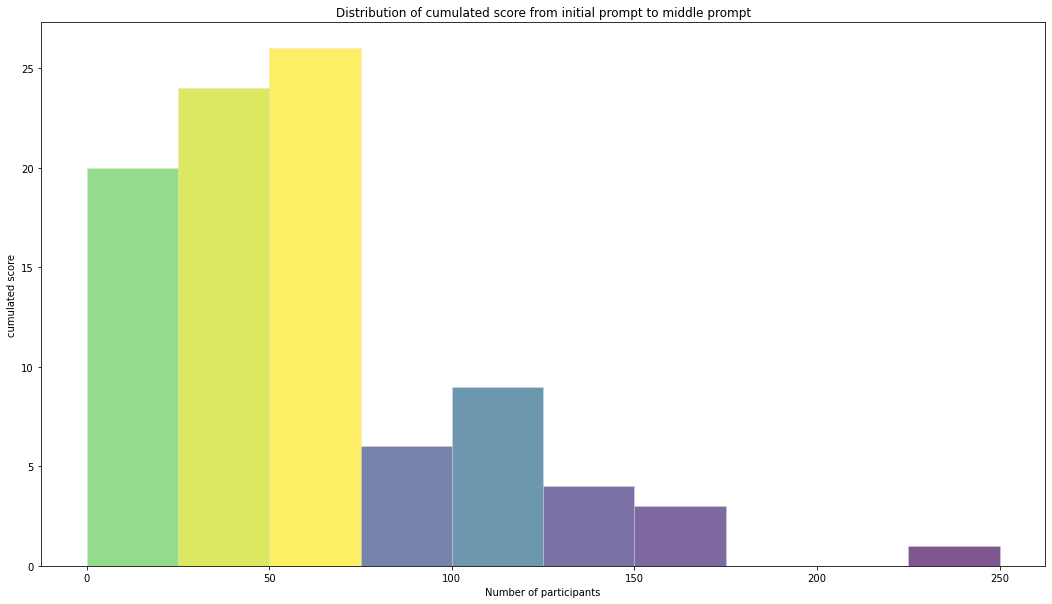

In [27]:
n, bins, patches = plt.hist(np.array(dataset_brut["score"]), bins=10, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
plt.xlabel("Number of participants")
plt.ylabel("cumulated score")
plt.title("Distribution of cumulated score from initial prompt to middle prompt")
plt.show()

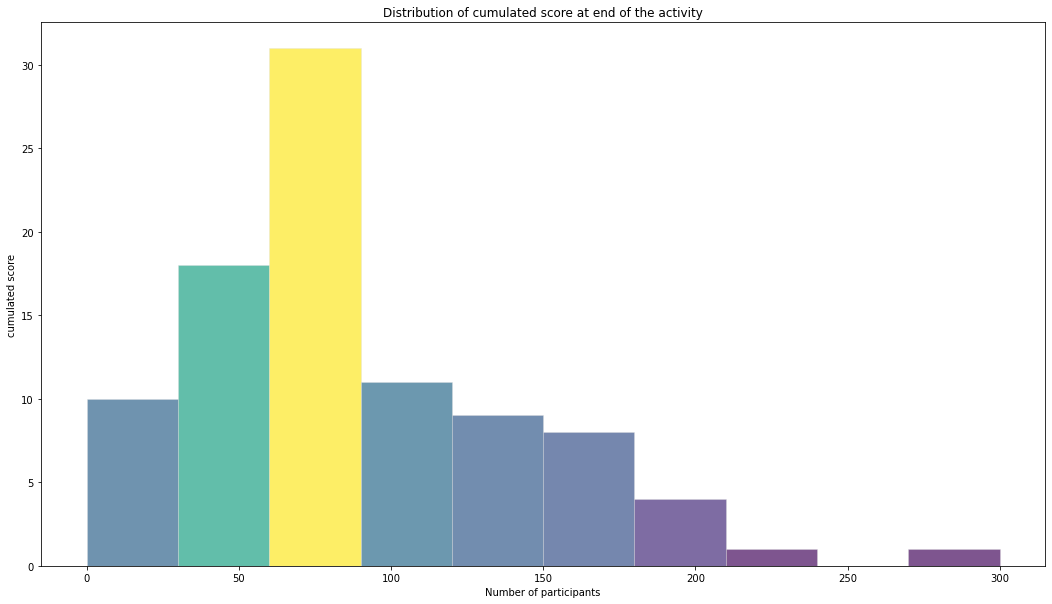

In [28]:
n, bins, patches = plt.hist(np.array(dataset_brut["score_1"]), bins=10, facecolor='#2ab0ff', edgecolor='#e0e0e0', 
                            linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
plt.xlabel("Number of participants")
plt.ylabel("cumulated score")
plt.title("Distribution of cumulated score at end of the activity")
density = stats.gaussian_kde(np.array(dataset_brut["score_1"]))
plt.show()